In [1]:
import numpy as np 
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [4]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

dataset_path = '/home/Pritam/python/csv_files/pokemon/PokemonData'
dataset = datasets.ImageFolder(root = dataset_path, transform = transform)

In [9]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
print(f"training size length: {len(train_dataset)}\ntest size length: {len(test_dataset)}")

training size length: 5456
test size length: 1364


In [10]:
train_data_loader = DataLoader(train_dataset ,batch_size = 32, shuffle = True)
test_data_loader = DataLoader(test_dataset, batch_size = 32, shuffle = False)

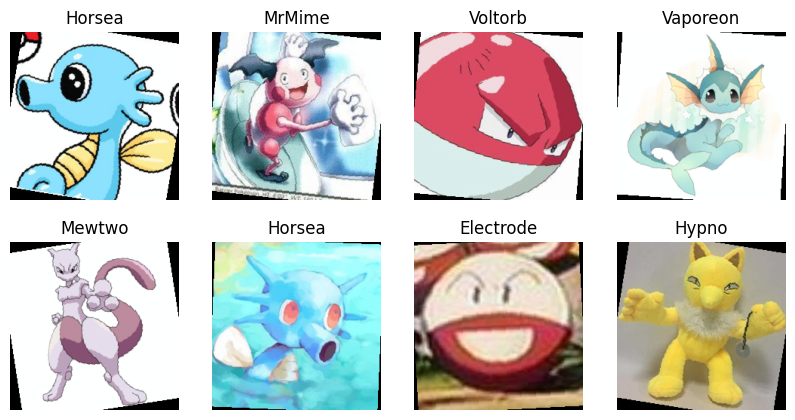

In [17]:
images, lables = next(iter(train_data_loader))
class_name = dataset.classes
fig, axis = plt.subplots(2, 4, figsize=(10, 5))
for i, ax in enumerate(axis.flat):
    img = images[i].permute(1, 2, 0).numpy()
    img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    img = np.clip(img, 0, 1)
    ax.imshow(img)
    ax.set_title(class_name[lables[i].item()])
    ax.axis('off')
plt.show()


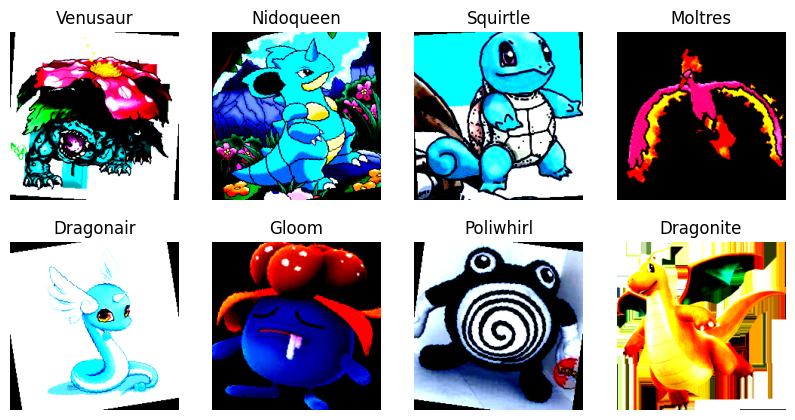

In [18]:
images, lables = next(iter(train_data_loader))
class_name = dataset.classes
fig, axis = plt.subplots(2, 4, figsize=(10, 5))
for i, ax in enumerate(axis.flat):
    img = images[i].permute(1, 2, 0).numpy()
    img = np.clip(img, 0, 1)
    ax.imshow(img)
    ax.set_title(class_name[lables[i].item()])
    ax.axis('off')
plt.show()


In [20]:
resnet_model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
resnet_model.fc = nn.Linear(in_features = 512, out_features = len(dataset.classes))
resnet_model = resnet_model.to(device)

In [30]:
def train_model(model, train_data, test_data, epochs):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr = 0.001)

    train_acc = []
    test_acc = []
    train_loss = []
    test_loss = []

    for epoch in range(epochs):
        model.train()
        total, correct, running_loss = 0, 0, 0.0

        for images, lables in train_data:
            images, lables = images.to(device), lables.to(device)

            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output, lables)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = output.max(1)
            total += lables.size(0)
            correct += predicted.eq(lables).sum().item()

        acc = 100 * correct / total
        val_acc, val_loss = eval_model(model, test_data, criterion)

        train_acc.append(acc)
        test_acc.append(val_acc)
        train_loss.append(running_loss / len(train_data))
        test_loss.append(val_loss)

        print(f"epoch: {epoch+1}/{epochs}, training loss: {running_loss / len(train_data):.4f}, training accuracy: {acc:.2f}, test loss: {val_loss:.4f}, test accuracy: {val_acc:.2f}")

    return train_acc, test_acc, train_loss, test_loss

def eval_model(model, test_data, criterion):
    model.eval()
    correct, total, running_loss = 0, 0, 0.0

    with torch.no_grad():
        for images, lables in test_data:
            images, lables = images.to(device), lables.to(device)

            output = model(images)
            loss = criterion(output, lables)
            running_loss += loss.item()
            _, predicted = output.max(1)
            total += lables.size(0)
            correct += predicted.eq(lables).sum().item()

            acc = 100 * correct / total
            test_loss = running_loss / len(test_data)

        return acc, test_loss



In [31]:
train_acc, test_acc, train_loss, test_loss = train_model(resnet_model, train_data_loader, test_data_loader, epochs = 5)

epoch: 0/5, training loss: 0.7029, training accuracy: 80.39, test loss: 1.3529, test accuracy: 66.13
epoch: 1/5, training loss: 0.4028, training accuracy: 88.62, test loss: 0.8449, test accuracy: 77.05
epoch: 2/5, training loss: 0.2831, training accuracy: 91.64, test loss: 0.7037, test accuracy: 81.96
epoch: 3/5, training loss: 0.2122, training accuracy: 94.34, test loss: 0.6651, test accuracy: 82.77
epoch: 4/5, training loss: 0.1713, training accuracy: 95.12, test loss: 0.7078, test accuracy: 82.62


In [38]:
def plot_metrices(train_acc, test_acc, train_loss, test_loss):
    epochs = range(1, len(train_acc)+1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_acc, label="Training accuracy", marker='o')
    plt.plot(epochs, test_acc, label="Testing accuracy", marker='o')
    plt.xlabel("Epochs")
    plt.ylabel("accuracy")
    plt.title("Training vs Validation accuracy")
    plt.legend()

    epochs1 = range(1, len(train_loss)+1)
    plt.subplot(1, 2, 2)
    plt.plot(epochs1, train_loss, label="Training loss", marker='o')
    plt.plot(epochs1, test_loss, label="Testing loss", marker='o')
    plt.xlabel("Epochs")
    plt.ylabel("loss")
    plt.title("Training vs Validation loss")
    plt.legend()

    plt.show()

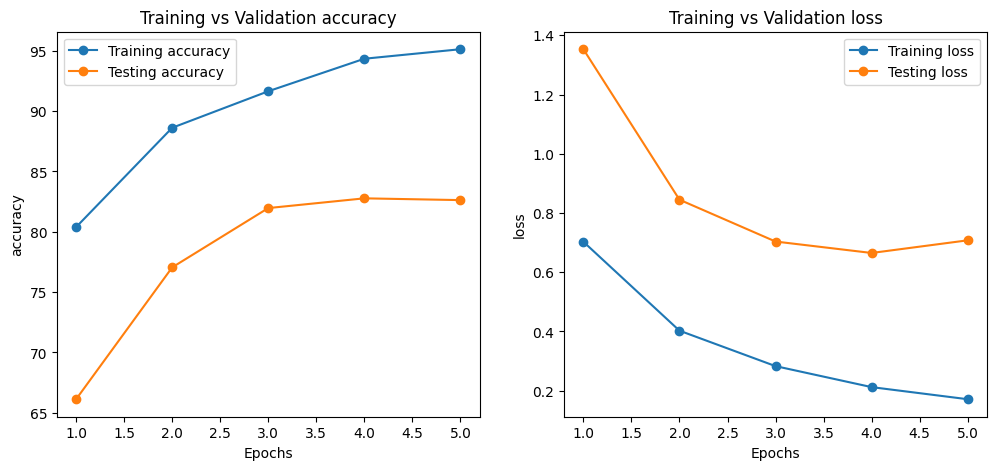

In [39]:
plot_metrices(train_acc, test_acc, train_loss, test_loss)

In [40]:
torch.save(resnet_model.state_dict(), "pokemon_classifier.pth")